In [3]:
# 测试环境
%run env.py
env = CombinatorialAuctionEnv(n_agents=5, n_items=3, max_steps=5)
obs = env.reset()
print("环境重置成功!")
print(f"观察: {obs}")
print(f"观察形状: {[o.shape for o in obs]}")

# 测试一步执5
actions = [env.action_space.sample() for _ in range(env.n_agents)]
print(f"随机动作: {actions}")

next_obs, rewards, done, info = env.step(actions)
print(f"执行成功! 奖励: {rewards}, 完成: {done}")
env.render()

环境重置成功!
观察: [array([6.98862664, 5.88584845, 0.18271174, 0.        , 0.        ,
       0.        , 0.        ]), array([8.18377839, 3.18366214, 8.30630911, 0.        , 0.        ,
       0.        , 0.        ]), array([5.78291224, 2.74425634, 7.10163947, 0.        , 0.        ,
       0.        , 0.        ]), array([5.00254417, 3.24844501, 5.32218178, 0.        , 0.        ,
       0.        , 0.        ]), array([7.29219717, 2.694859  , 2.30106637, 0.        , 0.        ,
       0.        , 0.        ])]
观察形状: [(7,), (7,), (7,), (7,), (7,)]
随机动作: [array([3.6840148, 8.454347 , 2.9146929], dtype=float32), array([3.2991076, 6.2098775, 8.500978 ], dtype=float32), array([5.043954 , 3.0622823, 8.001189 ], dtype=float32), array([7.8801475, 3.3668437, 6.901249 ], dtype=float32), array([2.8271072, 1.9409385, 2.503575 ], dtype=float32)]
执行成功! 奖励: [-0.32402904  0.30511988  0.         -0.04140973  0.        ], 完成: False

=== 回合 1 ===
真实估值:
  智能体 0: [6.98862664 5.88584845 0.18271174]
  智能体 1: [8

In [10]:
# 测试 MADDPG
%run maddpg.py

# 使用与环境相同的参数
n_agents = 5
obs_dims = [env.obs_dim] * n_agents  # 注意使用 env.obs_dim 而不是 env.n_items
act_dims = [env.n_items] * n_agents

maddpg = MADDPG(n_agents, obs_dims, act_dims)
print("MADDPG 初始化成功!")

# 测试动作生成
test_obs = env.reset()
test_obs = [test_obs[i] for i in range(env.n_agents)]  # 关键修复点
test_actions = maddpg.act(test_obs)
print(f"MADDPG 生成的动作: {test_actions}")

MADDPG 初始化成功!
MADDPG 生成的动作: [array([0.45487118, 0.4929095 , 0.57502323], dtype=float32), array([0.55903107, 0.5136407 , 0.49622586], dtype=float32), array([0.5068299 , 0.4503498 , 0.51070267], dtype=float32), array([0.48752928, 0.29470617, 0.6710592 ], dtype=float32), array([0.4592678 , 0.42719597, 0.45383254], dtype=float32)]


In [11]:
# 简化训练循环
import numpy as np

# 重置环境
obs_list = env.reset()
done = False
episode_reward = 0

step_rewards = []        # 每一步的总奖励
cumulative_rewards = []  # 每一步的累计总奖励

while not done:
    # 使用 MADDPG 生成动作
    actions = maddpg.act(obs_list)
    
    # 执行动作
    next_obs_list, rewards, done, info = env.step(actions)
    
    step_total = np.sum(rewards)
    episode_reward += step_total
    
    step_rewards.append(step_total)
    cumulative_rewards.append(episode_reward)
    
    # 存储经验
    maddpg.buffer.add((obs_list, actions, rewards, next_obs_list, done))
    
    # 更新观察
    obs_list = next_obs_list
    
    print(f"步骤奖励: {rewards}, 步骤总和: {step_total}, 累计奖励: {episode_reward}")

print(f"回合结束，总奖励: {episode_reward}")


# 尝试更新 MADDPG
print("尝试更新 MADDPG...")
maddpg.update(batch_size=32)
print("更新完成!")

步骤奖励: [ 0.         12.59861519  0.          6.00691988  0.        ], 步骤总和: 18.605535071621972, 累计奖励: 18.605535071621972
步骤奖励: [0.         8.46500421 4.63644725 6.01221391 0.        ], 步骤总和: 19.11366536761279, 累计奖励: 37.71920043923476
步骤奖励: [0.         8.4667238  4.63553408 6.00998303 0.        ], 步骤总和: 19.112240906009625, 累计奖励: 56.831441345244386
步骤奖励: [0.         8.46840787 4.63436121 6.00771274 0.        ], 步骤总和: 19.11048182393069, 累计奖励: 75.94192316917508
步骤奖励: [ 0.         12.60550051  0.          6.00594302  0.        ], 步骤总和: 18.611443531046945, 累计奖励: 94.55336670022203
回合结束，总奖励: 94.55336670022203
尝试更新 MADDPG...
更新完成!


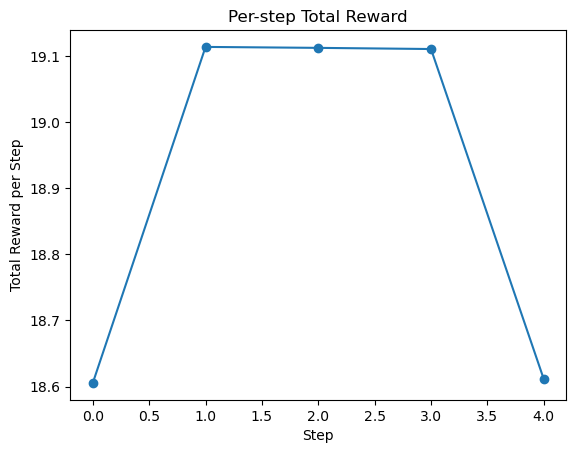

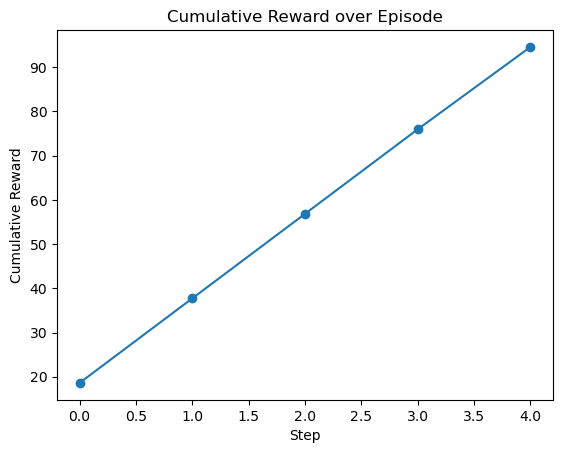

In [12]:
# 可视化 1：奖励曲线
import matplotlib.pyplot as plt

# 在 Jupyter 里用
%matplotlib inline

plt.figure()
plt.plot(step_rewards, marker='o')
plt.xlabel("Step")
plt.ylabel("Total Reward per Step")
plt.title("Per-step Total Reward")

plt.figure()
plt.plot(cumulative_rewards, marker='o')
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward over Episode")

plt.show()


utilities 形状: (5, 5)


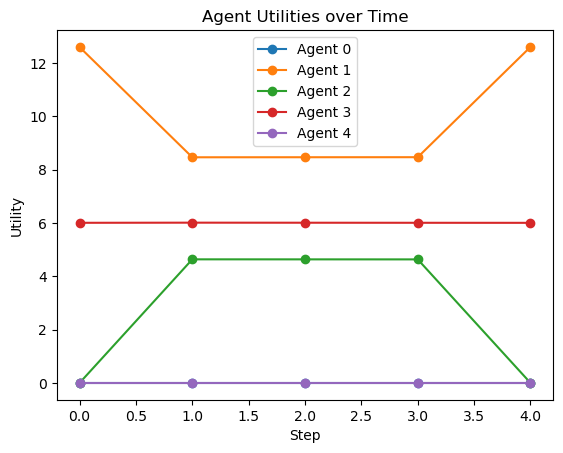

In [13]:
# 可视化 2：每个智能体的效用曲线
import numpy as np
import matplotlib.pyplot as plt

utilities = np.array(env.history['utilities'])  # 形状: (T, n_agents)

print("utilities 形状:", utilities.shape)

plt.figure()
for i in range(env.n_agents):
    plt.plot(utilities[:, i], marker='o', label=f"Agent {i}")
plt.xlabel("Step")
plt.ylabel("Utility")
plt.title("Agent Utilities over Time")
plt.legend()
plt.show()


items_per_agent: [0 7 3 5 0]


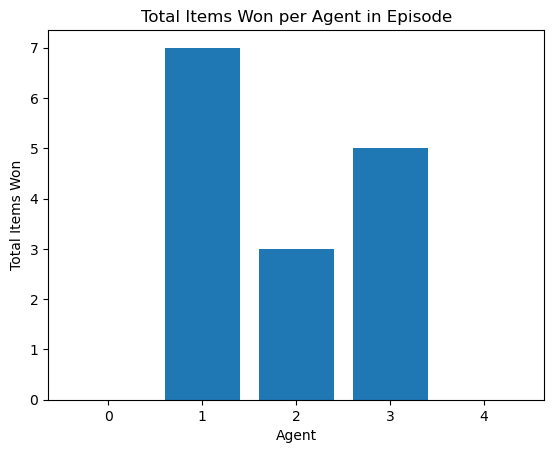

In [14]:
# 可视化 3：每个智能体获得物品数量
import numpy as np
import matplotlib.pyplot as plt

# allocations: list of (n_agents, n_items) 的布尔矩阵
allocations = np.array(env.history['allocations'])  # 形状: (T, n_agents, n_items)

# 对时间和物品维度求和，得到每个智能体在整个回合获得的物品总数
items_per_agent = allocations.sum(axis=(0, 2))

print("items_per_agent:", items_per_agent)

plt.figure()
plt.bar(range(env.n_agents), items_per_agent)
plt.xlabel("Agent")
plt.ylabel("Total Items Won")
plt.title("Total Items Won per Agent in Episode")
plt.show()


In [17]:
#check (这些应该都一样)
print("env.n_agents =", env.n_agents)
print("MADDPG n =", maddpg.n)
print("len(test_obs) =", len(test_obs))
print("len(maddpg.actors) =", len(maddpg.actors))


env.n_agents = 5
MADDPG n = 5
len(test_obs) = 5
len(maddpg.actors) = 5
